In [22]:
import os
import numpy as np
import json
import csv
from PIL import Image, ImageDraw
import cv2
from matplotlib.pyplot import imshow

In [215]:
SCALE_FACTOR = 2

def draw_rectangle(I, xy):
    img = Image.fromarray(I)
    draw = ImageDraw.Draw(img)
    draw.rectangle([xy[1], xy[0], xy[3], xy[2]])
    text = str(np.round(xy[4], 2))
    draw.text((xy[1], xy[0] - 10), text)
    del draw
    return img


def downsample(I, factor):
    assert(I.shape[0] % factor == 0 and I.shape[1] % factor == 0)
    input_size = I.shape[:2]
    output_size = [dim // factor for dim in I.shape[:2]]
    small_image = I.reshape((output_size[0], factor, 
                             output_size[1], factor, 3)).max(3).max(1)
    return small_image


def calc_iou(A, B):
    # Checks if bbox A and B intersect at all
    # A fixed, B intersects top
    summed_area = ((A[2] - A[0]) * (A[3] - A[1]) +
                   (B[2] - B[0]) * (B[3] - B[1]))
    i_area = 0
    if A[1] >= B[1] and A[1] <= B[3]:
        # intersects topleft
        if A[0] >= B[0] and A[0] <= B[2]:
            i_area = (B[2] - A[0]) * (B[3] - A[1])
        # intersects topright
        elif A[2] >= B[0] and A[2] <= B[2]:
            i_area = (A[2] - B[0]) * (B[3] - A[1])
    # B intersects bottom
    elif A[3] >= B[1] and A[3] <= B[3]:
        # intersects bottomleft
        if A[0] >= B[0] and A[0] <= B[2]:
            i_area = (B[2] - A[0]) * (A[3] - B[1])
        # intersects bottomright
        elif A[2] >= B[0] and A[2] <= B[2]:
            i_area = (A[2] - B[0]) * (A[3] - B[1])
    
    return i_area / (summed_area - i_area)

assert(calc_iou([0, 0, 10, 10], [5, 5, 15, 15]) == 25 / 175)


def run_nms(bboxes, iou_thres=0.1):
    # Assume bboxes' 4 coord is conf
    valid_bboxes = []
    bboxes = sorted(bboxes, key=lambda x:x[4], reverse=True)

    for bbox in bboxes:
        is_valid = True
        for valid_bbox in valid_bboxes:
            if calc_iou(bbox, valid_bbox) > iou_thres:
                is_valid = False
                break
        if is_valid:
            valid_bboxes.append(bbox)
    return valid_bboxes


def rgb_to_hsv(I):
    '''
    Turn a numpy RGB image to a numpy HSV image
    '''
    I = I / 255.0
    cmax = np.max(I, axis=2)
    cmin = np.min(I, axis=2)
    diff = cmax - cmin
    max_color = np.argmax(I, axis=2)
    # initialize hsv
    h = np.zeros(I.shape[:2])
    s = np.zeros(I.shape[:2])
    v = cmax * 100
    # calculate h, s
    for i in range(h.shape[0]):
        for j in range(h.shape[1]):
            # saturation
            if cmax[i, j] > 0:
                s[i, j] = diff[i, j] / cmax[i, j] * 100
            # Both are zero
            if cmax[i, j] == cmin[i, j]:
                continue
            # r
            if max_color[i, j] == 0:
                h[i, j] = (60 * ((I[i, j, 1] - I[i, j, 2]) / diff[i, j]) + 360) % 360
            # g
            if max_color[i, j] == 1:
                h[i, j] = (60 * ((I[i, j, 2] - I[i, j, 0]) / diff[i, j]) + 120) % 360
            # b
            if max_color[i, j] == 2:
                h[i, j] = (60 * ((I[i, j, 0] - I[i, j, 1]) / diff[i, j]) + 240) % 360
    # Flip hue so that red is in the 180 band instead of 0, 360 band
    h  = (h + 180) % 360
    """
    print('h:', h[:5, :5])
    print('s:', s[:5, :5])
    print('v:', v[:5, :5])
    print('h:', h)
    print('s:', s)
    print('v:', v)
    if h.shape[0] > 300:
        cv2.imshow('image', h / 2)
        cv2.waitKey(0)
        cv2.imshow('image', s)
        cv2.waitKey(0)
        cv2.imshow('image', v)
        cv2.waitKey(0)
    """
    return np.stack([h, s, v]).transpose([1,2,0]).astype(np.uint8)


def normalize_image(img, source_img=None, axis=None):
    if source_img is None:
        source_img = img
    return (
        (
            img
            # - source_img.mean(axis=axis, keepdims=True)
        ) /
        np.linalg.norm(source_img)
    )


def process_filters(img, read_only=False):
    if read_only:
        img = img.copy()
    hsv = rgb_to_hsv(img)
    img = np.concatenate((img, hsv), axis=2)
    return img


def imshow_hsv(I):
    cv2_hsv = I.copy()
    cv2_hsv[:,:,0] /= 2
    cv2_hsv[:,:,1] *= 2.55
    cv2_hsv[:,:,2] *= 2.55
    cv2_hsv = np.round(cv2_hsv).astype(np.uint8)
    #print('viewed h:', cv2_hsv[:5, :5, 0])
    #print('viewed s:', cv2_hsv[:5, :5, 1])
    #print('viewed v:', cv2_hsv[:5, :5, 2])
    #print('viewed hsv:', cv2_hsv, cv2_hsv.shape, cv2_hsv.dtype)
    #proper_hsv = cv2.cvtColor(original_I, cv2.COLOR_RGB2HSV)
    #print("proper hsv:", proper_hsv, proper_hsv.shape, proper_hsv.dtype)
    #print(cv2_hsv.shape)
    cv2.imshow('image', cv2.cvtColor(cv2_hsv, cv2.COLOR_HSV2BGR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    """cv2.imshow('image', cv2_hsv[:, :, 0])
    cv2.waitKey(0)
    cv2.imshow('image', cv2_hsv[:, :, 1])
    cv2.waitKey(0)
    cv2.imshow('image', cv2_hsv[:, :, 2])
    cv2.waitKey(0)"""

    
def imshow_rgb(I):
    cv2.imshow('image', cv2.cvtColor(I, cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def imshow_mpl_rgb(I):
    imshow(I)

    
def imshow_mpl_hsv(I):
    cv2_hsv = I.copy().astype(np.float)
    cv2_hsv[:,:,0] /= 2
    cv2_hsv[:,:,1] *= 2.55
    cv2_hsv[:,:,2] *= 2.55
    cv2_hsv = np.round(cv2_hsv).astype(np.uint8)
    imshow(cv2.cvtColor(cv2_hsv, cv2.COLOR_HSV2RGB))

In [266]:
class Filter:
    def __init__(self, filepath, thres, sourcepath, factor=SCALE_FACTOR):
        self.factor = factor
        rgb_source_I = np.asarray(Image.open(os.path.join(sourcepath)))
        self.rgb_source_I = rgb_source_I
        rgb_source_I = downsample(rgb_source_I, self.factor)
        self.source_I = process_filters(rgb_source_I, read_only=True)
        rgb_ref_I = np.asarray(Image.open(os.path.join(filepath)))
        self.rgb_ref_I = rgb_ref_I
        rgb_ref_I = downsample(rgb_ref_I, self.factor)
        rgb_ref_I = process_filters(rgb_ref_I, read_only=True)
        self.unnorm_rgb_ref_I = rgb_ref_I
        print(rgb_ref_I[:rgb_ref_I.shape[0] // 2].mean(axis=0).mean(axis=0))
        print(rgb_ref_I[rgb_ref_I.shape[0] // 2:].mean(axis=0).mean(axis=0))
        self.ref_I = normalize_image(rgb_ref_I)
        self.ref_vec = self.ref_I.flatten()
        print(self.ref_I.shape, self.source_I.mean())
        self.ref_rows, self.ref_cols = self.ref_I.shape[:2]
        self.thres = thres
        
        # means for filtering
        self.top_means = self.unnorm_rgb_ref_I[:self.ref_rows//2].mean(axis=0).mean(axis=0)
        self.bottom_means = self.unnorm_rgb_ref_I[self.ref_rows//2:].mean(axis=0).mean(axis=0)
        # rgb hsv
        self.top_tols = [
            [-20, 1000],
            [-1000, 10],
            [-1000, 10],
            [-15, 15],
            [-15, 1000],
            [-15, 1000],
        ]
        self.bottom_tols = [
            [-1000, 1000],
            [-1000, 1000],
            [-1000, 1000],
            [-1000, 1000],
            [-1000, 1000],
            [-1000, 20],
        ]


    def test_handcrafted_filter(self, sub_mat):
        img_top_means = sub_mat[:sub_mat.shape[0]//2].mean(axis=0).mean(axis=0)
        img_bottom_means = sub_mat[sub_mat.shape[0]//2:].mean(axis=0).mean(axis=0)
        
        for i, tol in enumerate(self.top_tols):
            if img_top_means[i] < self.top_means[i] + tol[0] or img_top_means[i] > self.top_means[i] + tol[1]:
                return False
        for i, tol in enumerate(self.top_tols):
            if img_bottom_means[i] < self.bottom_means[i] + tol[0] or img_bottom_means[i] > self.bottom_means[i] + tol[1]:
                return False
        return True


    def get_detections(self, I):
        # Assume I is already downsampled and processed
        # run convolution
        n_rows, n_cols = I.shape[:2]
        bboxes = []
        confs = []
        print(I.mean())
        ind = 0
        for row in range(0, int(n_rows * 0.7) - self.ref_rows, max(self.ref_rows // 10, 1)):
            for col in range(0, n_cols - self.ref_cols, max(self.ref_cols // 10, 1)):
                ind += 1
                if ind % 1 != 0:
                    continue
                sub_mat = I[row:row+self.ref_rows,
                            col:col+self.ref_cols]
                if not self.test_handcrafted_filter(sub_mat):
                    continue
                # sub_mat = process_filters(sub_mat)
                sub_vec = normalize_image(sub_mat.flatten())
                conf = np.dot(sub_vec, self.ref_vec)
                if row == 197 // 2 and col == 463 // 2:
                    print("YOLO:", conf)
                confs.append(conf)
                if conf > self.thres:
                    print('conf', conf, 'means', sub_mat[:sub_mat.shape[0]//2].mean(axis=0).mean(axis=0),
                          'coords:', col, row)
                    ind -= 1
                    bboxes.append([
                        row * self.factor, col * self.factor,
                        (row+self.ref_rows) * self.factor,
                        (col+self.ref_cols) * self.factor,
                        conf
                    ])
        
        print(sorted(confs)[-10:])
        print('num boxes:', len(bboxes))
        return bboxes

In [259]:
def detect_red_light_mf(I, det_filters, factor=SCALE_FACTOR):
    '''
    This function takes a numpy array <I> and returns a list <output>.
    The length of <output> is the number of bounding boxes predicted for <I>. 
    Each entry of <output> is a list <[row_TL,col_TL,row_BR,col_BR,score]>. 
    The first four entries are four integers specifying a bounding box 
    (the row and column index of the top left corner and the row and column 
    index of the bottom right corner).
    <score> is a confidence score ranging from 0 to 1. 

    Note that PIL loads images in RGB order, so:
    I[:,:,0] is the red channel
    I[:,:,1] is the green channel
    I[:,:,2] is the blue channel
    '''

    '''
    BEGIN YOUR CODE
    '''

    bboxes = [] # This should be a list of lists, each of length 4. See format example below. 
    
    '''
    BEGIN YOUR CODE
    '''
    
    '''
    As an example, here's code that generates between 1 and 5 random boxes
    of fixed size and returns the results in the proper format.
    '''
    
    (n_rows,n_cols,n_channels) = np.shape(I)
    
    original_I = I.copy()
    # downsample
    I = downsample(I, factor)
    I = process_filters(I)

    bboxes = []
    for det_filter in det_filters:
        # Similar to predict_boxes(compute_convolution(I, T))
        bboxes.extend(det_filter.get_detections(I))

    print('# bboxes before nms:', len(bboxes))
    bboxes = run_nms(bboxes)
    print('# bboxes after nms:', len(bboxes))
    bboxes = sorted(bboxes, key=lambda x: x[4])
    print("Best bboxes:\n", bboxes[-10:])

    if len(bboxes) == 0:
        return bboxes

    for bbox in bboxes[-10:]:
        original_I = draw_rectangle(original_I, bbox)
        original_I = np.asarray(original_I)

    imshow_rgb(original_I)

    output = bboxes
    '''
    END YOUR CODE
    '''
    for i in range(len(output)):
        assert len(output[i]) == 5
        assert (output[i][4] >= 0.0) and (output[i][4] <= 1.0)

    return output

In [221]:
def get_det_filters(filters_path, filters_info_filename):
    # get detection filters
    det_filters = []
    with open(os.path.join(filters_path, filters_info_filename)) as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        # next(reader)
        # next(reader)
        for row in reader:
            det_filters.append(
                Filter(
                    os.path.join(filters_path, row[0]),
                    float(row[1]),
                    os.path.join(filters_path, row[2]),
                ))
    return det_filters

In [222]:
# Note that you are not allowed to use test data for training.
# set the path to the downloaded data:
data_path = '../data/RedLights2011_Medium'

# set the path to load the filters csv:
filters_path = '../data/filters'
filters_info_filename = 'thresholds.csv'

# load splits: 
split_path = '../data/hw02_splits'
file_names_train = np.load(os.path.join(split_path,'file_names_train.npy'))
file_names_test = np.load(os.path.join(split_path,'file_names_test.npy'))

# set a path for saving predictions:
preds_path = '../data/hw02_preds'
os.makedirs(preds_path, exist_ok=True) # create directory if needed

# Set this parameter to True when you're done with algorithm development:
done_tweaking = False

# get detection filters
det_filters = get_det_filters(filters_path, filters_info_filename)

[178.16666667  60.26190476  75.0952381  174.30952381  73.73809524
  69.38095238]
(12, 7, 6) 45.89083333333333
[ 87.57142857  46.21428571  44.21428571 182.07142857  48.0952381
  33.88095238]
(12, 7, 6) 71.91898654513889
[174.04 121.28  99.6  194.88  45.12  67.88]
(11, 5, 6) 69.98797092013889
[ 97.58333333  32.02777778  45.83333333 148.91666667  58.66666667
  38.58333333]
(12, 6, 6) 57.430201822916665


In [223]:
# det_filters = [det_filters[-1]]

In [149]:
filter_ind = 2

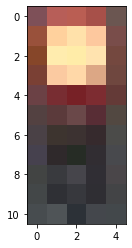

In [150]:
imshow_mpl_rgb(downsample(det_filters[filter_ind].rgb_ref_I, 2))

In [152]:
ref = det_filters[filter_ind].rgb_ref_I
print(ref[:,:,0])
print(ref.shape)

[[111 116 142 156 167 167 148 134 104 107]
 [109 126 164 183 185 186 167 132 102 107]
 [126 137 190 231 243 239 201 135 114 121]
 [130 153 228 255 255 255 253 161 111 120]
 [131 134 230 255 254 253 255 160 106 116]
 [126 131 234 255 251 255 255 157 101 112]
 [120 122 194 251 255 255 220 140 102 111]
 [105 118 132 160 169 175 132 112  96 106]
 [107 107 120 118 119 119 125 113 100  97]
 [ 93  92  93  96 104 105 101  92  87  86]
 [ 83  83  80  91 106 105  88  81  72  82]
 [ 72  76  69  84  96  97  76  69  57  75]
 [ 70  70  60  61  55  60  54  53  52  73]
 [ 74  70  55  44  25  31  41  51  52  75]
 [ 70  64  47  39  24  27  38  49  49  70]
 [ 67  55  39  37  34  38  39  47  56  72]
 [ 66  54  37  34  42  46  35  48  57  74]
 [ 61  57  43  57  69  70  47  45  56  72]
 [ 64  61  41  47  49  55  45  47  50  67]
 [ 67  54  40  41  38  33  30  45  52  67]
 [ 60  71  79  44  27  38  53  68  50  63]
 [ 62  54  70  48  44  44  47  58  55  67]]
(22, 10, 3)


In [160]:
det_filters[filter_ind].ref_rows

5

In [170]:
gt_coords = [
    [],
    [],
    [176,323],
    [],
    [197, 463]
]
gt = det_filters[filter_ind].rgb_source_I[gt_coords[filter_ind][0]:gt_coords[filter_ind][0]+(det_filters[filter_ind].ref_rows * SCALE_FACTOR),
                                          gt_coords[filter_ind][1]:gt_coords[filter_ind][1]+(det_filters[filter_ind].ref_cols * SCALE_FACTOR),:]
# gt[:,:,0]

In [207]:
gt[:11].mean(axis=0).mean(axis=0), rgb_to_hsv(gt)[:11].mean(axis=0).mean(axis=0)

(array([144.57272727,  89.68181818,  81.72727273]),
 array([177.74545455,  45.47272727,  56.36363636]))

In [206]:
nice_gt = det_filters[filter_ind].rgb_source_I[gt_coords[filter_ind][0]:gt_coords[filter_ind][0]+(det_filters[-1].ref_rows * SCALE_FACTOR),
                                          gt_coords[filter_ind][1]:gt_coords[filter_ind][1]+(det_filters[-1].ref_cols * SCALE_FACTOR),:]
nice_gt[:10, :8].mean(axis=0).mean(axis=0), rgb_to_hsv(nice_gt[:10, :8]).mean(axis=0).mean(axis=0)  

(array([152.1875,  82.2375,  70.575 ]), array([183.5875,  56.2625,  59.3125]))

In [205]:
nice_gt[:20,:8,0]

array([[ 95, 108, 147, 187, 189, 159, 114,  87],
       [102, 132, 185, 210, 206, 178, 146, 108],
       [120, 171, 230, 243, 251, 221, 161, 127],
       [130, 198, 255, 255, 255, 255, 188, 133],
       [127, 178, 255, 255, 248, 255, 177, 118],
       [110, 144, 219, 255, 255, 225, 150, 109],
       [ 91, 118, 153, 188, 202, 163, 134, 100],
       [ 87, 102, 129, 147, 157, 146, 127, 100],
       [ 85,  94,  93, 108, 114, 102,  94,  90],
       [ 81,  83,  74,  84,  91,  73,  72,  67],
       [ 72,  74,  67,  81,  89,  64,  62,  55],
       [ 64,  65,  59,  67,  67,  58,  51,  53],
       [ 66,  63,  53,  53,  43,  47,  42,  52],
       [ 70,  61,  43,  41,  33,  33,  42,  52],
       [ 67,  56,  35,  34,  37,  35,  48,  55],
       [ 66,  60,  45,  51,  64,  52,  56,  60],
       [ 65,  58,  40,  47,  45,  41,  37,  49],
       [ 66,  54,  47,  33,  36,  31,  45,  45],
       [ 62,  67,  78,  44,  36,  44,  73,  52],
       [ 63,  61,  67,  49,  44,  55,  54,  56]], dtype=uint8)

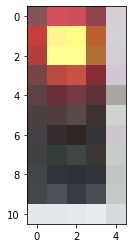

In [171]:
imshow_mpl_rgb(downsample(gt, 2))

In [172]:
downsample(rgb_to_hsv(gt), 2)[:,:,0]

array([[176, 175, 178, 181, 182],
       [182, 234, 240, 201, 183],
       [184, 240, 243, 208, 180],
       [182, 185, 186, 180, 164],
       [174, 163, 168, 190, 205],
       [180, 180, 180, 207, 229],
       [180, 180, 192, 149, 120],
       [165, 180, 180, 202, 180],
       [ 37,  42,  32,  37,  89],
       [ 37,  42,  41,  37,  25],
       [ 37,  37,  32,  37,  25]], dtype=uint8)

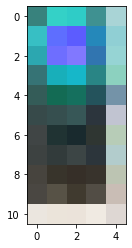

In [174]:
imshow_mpl_hsv(downsample(rgb_to_hsv(gt), 2))

In [176]:
downsample(rgb_to_hsv(gt), 2).copy()[:,:,0]

array([[176, 175, 178, 181, 182],
       [182, 234, 240, 201, 183],
       [184, 240, 243, 208, 180],
       [182, 185, 186, 180, 164],
       [174, 163, 168, 190, 205],
       [180, 180, 180, 207, 229],
       [180, 180, 192, 149, 120],
       [165, 180, 180, 202, 180],
       [ 37,  42,  32,  37,  89],
       [ 37,  42,  41,  37,  25],
       [ 37,  37,  32,  37,  25]], dtype=uint8)

In [196]:
coords = [262, 168]
fp = det_filters[-1].rgb_source_I[coords[0]:coords[0]+24,coords[1]:coords[1]+12,:]
# fp[:,:,0]

fp_coords = [
    [],
    [],
    [],
    [],
    [262, 168] # [234, 624] 
]
gt = det_filters[filter_ind].rgb_source_I[gt_coords[filter_ind][0]:gt_coords[filter_ind][0]+(det_filters[filter_ind].ref_rows * SCALE_FACTOR),
                                          gt_coords[filter_ind][1]:gt_coords[filter_ind][1]+(det_filters[filter_ind].ref_cols * SCALE_FACTOR),:]
# gt[:,:,0]

In [197]:
fp[:12].mean(axis=0).mean(axis=0)

array([73.86111111, 59.09722222, 51.75      ])

In [193]:
fp[:12].mean(axis=0).mean(axis=0)

array([6.82638889, 8.82638889, 7.82638889])

In [180]:
print(
    np.sum(normalize_image(ref) * normalize_image(gt)),
    np.sum(normalize_image(gt) * normalize_image(gt)),
    #np.sum(normalize_image(ref) * normalize_image(fp)),
    np.sum(normalize_image(rgb_to_hsv(ref)) * normalize_image(rgb_to_hsv(gt))),
    #np.sum(normalize_image(rgb_to_hsv(ref)) * normalize_image(rgb_to_hsv(fp))),
)

0.8585721842391871 1.0 0.946382409546846


In [179]:
print(
    np.sum(normalize_image(downsample(ref, 2)) * normalize_image(downsample(gt, 2))),
    #np.sum(normalize_image(downsample(ref, 2)) * normalize_image(downsample(fp, 2))),
    np.sum(normalize_image(rgb_to_hsv(downsample(ref, 2))) * normalize_image(rgb_to_hsv(downsample(gt, 2)))),
    #np.sum(normalize_image(rgb_to_hsv(downsample(ref, 2))) * normalize_image(rgb_to_hsv(downsample(fp, 2)))),
)

0.8388298853724335 0.9460359908007037


In [136]:
print(
    np.sum(normalize_image(downsample(ref, 2)) * normalize_image(downsample(gt, 2))),
    np.sum(normalize_image(downsample(ref, 2)) * normalize_image(downsample(fp, 2))),
    np.sum(normalize_image(rgb_to_hsv(downsample(ref, 2))) * normalize_image(rgb_to_hsv(downsample(gt, 2)))),
    np.sum(normalize_image(rgb_to_hsv(downsample(ref, 2))) * normalize_image(rgb_to_hsv(downsample(fp, 2)))),
)

0.9943785329164838 0.2997970813785265 0.948233244120727 0.8134053044443802


In [264]:
det_filters = get_det_filters(filters_path, filters_info_filename)

[178.16666667  60.26190476  75.0952381  174.30952381  73.73809524
  69.38095238]
[ 76.26190476   7.78571429  14.78571429 173.19047619  86.0952381
  29.38095238]
(12, 7, 6) 45.89083333333333
[138.875   72.4375  70.4375 182.125   54.5625  53.9375]
[ 39.15  30.65  28.3  202.4   25.35  14.75]
(9, 4, 6) 71.91898654513889
[174.04 121.28  99.6  194.88  45.12  67.88]
[ 65.9         60.53333333  63.06666667 101.5         14.1
  26.73333333]
(11, 5, 6) 69.98797092013889
[140.55555556  53.88888889  75.         165.55555556  62.11111111
  54.44444444]
[33.41666667 30.66666667 36.08333333 77.91666667 21.75       14.58333333]
(7, 3, 6) 90.2045724826389
[119.38690476  72.29166667  49.44047619 183.35119048  54.24404762
  46.5297619 ]
[ 33.17777778  31.95555556  32.77222222 102.24444444  11.53888889
  13.20555556]
(29, 12, 6) 74.79226996527778
[ 97.58333333  32.02777778  45.83333333 148.91666667  58.66666667
  38.58333333]
[18.36111111 22.44444444 26.19444444 50.11111111 31.25       10.08333333]
(12, 6

In [265]:
'''
Make predictions on the training set.
'''
preds_train = {}
for i in range(len(file_names_train)):
    file_names_train[i] = 'RL-011.jpg'
    print('file name:', file_names_train[i])
    # read image using PIL:
    I = Image.open(os.path.join(data_path,file_names_train[i]))

    # convert to numpy array:
    I = np.asarray(I)

    preds_train[file_names_train[i]] = detect_red_light_mf(I, det_filters)
    break

# save preds (overwrites any previous predictions!)
with open(os.path.join(preds_path,'preds_train.json'),'w') as f:
    json.dump(preds_train,f)

if done_tweaking:
    '''
    Make predictions on the test set. 
    '''
    preds_test = {}
    for i in range(len(file_names_test)):

        # read image using PIL:
        I = Image.open(os.path.join(data_path,file_names_test[i]))

        # convert to numpy array:
        I = np.asarray(I)

        preds_test[file_names_test[i]] = detect_red_light_mf(I)

    # save preds (overwrites any previous predictions!)
    with open(os.path.join(preds_path,'preds_test.json'),'w') as f:
        json.dump(preds_test,f)

file name: RL-011.jpg
74.79226996527778
[]
num boxes: 0
74.79226996527778
[]
num boxes: 0
74.79226996527778
[]
num boxes: 0
74.79226996527778
[]
num boxes: 0
74.79226996527778
conf 0.9140703267758535 means [117.54761905  73.70238095  48.2202381  183.93452381  50.19047619
  45.7202381 ] coords: 81 30
conf 0.9477658494491499 means [118.94047619  73.4702381   48.26190476 183.63690476  52.04166667
  46.26190476] coords: 82 30
conf 0.9547258279221053 means [119.01190476  73.51785714  48.16666667 184.08928571  52.21428571
  46.28571429] coords: 83 30
conf 0.926289877392634 means [118.10119048  73.42857143  48.42261905 181.7202381   51.5297619
  45.97619048] coords: 84 30
conf 0.958462449768015 means [121.31547619  73.07142857  49.63690476 181.69642857  54.42261905
  47.23214286] coords: 176 34
conf 0.9368988792632226 means [121.57738095  75.05357143  51.73214286 171.39880952  53.07738095
  47.64285714] coords: 177 34
conf 0.9400108773444051 means [118.61904762  72.85714286  48.89285714 181.7

In [273]:
import multiprocessing

def worker(procnum, return_dict):
    '''worker function'''
    print(str(procnum) + ' represent!')
    return_dict[procnum] = procnum


if __name__ == '__main__':
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs = []
    for i in range(5):
        p = multiprocessing.Process(target=worker, args=(i,return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    print(return_dict.values())

[]


In [272]:
return_dict.values()

[]